<b>Group Number:</b> 
<br><b>Name Group Member 1:</b> 
<br><b>u-Kürzel Group Member 1:</b> 
<br><b>Name Group Member 2:</b> 
<br><b>u-Kürzel Group Member 2:</b> 

# 3 - PCA and Clustering with Samsung Human Activity Recognition Dataset (3)

In this part of the task, we will work with the [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. The dataset resides in the folder "data". The data comes from accelerometers and gyros of Samsung Galaxy S3 mobile phones (you can find more info about the features using the link above). The type of activity of a person with a phone in his/her pocket is also known – whether he/she walked, stood, lay, sat or walked up or down the stairs.

First, we pretend that the type of activity is unknown to us, and we will try to cluster people purely on the basis of available features. Then, we solve the problem of determining the type of physical activity as a classification problem.

## 3.1 Preparation

We import the necessary libraries Pandas, Seaborn, Numpy. From scikit-learn, import the metrics, KMeans, PCA, GridSearchCV, StandardScaler and some other necessary imports and definitions.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import os
from typing import *
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors
%matplotlib inline
plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from lama.test_functions import UnsupervisedLearning_Tests

test_func = UnsupervisedLearning_Tests()

#Define a fixed random state
RANDOM_STATE = 42

### 3.1.1 Import your dataset

Let's proceed with importing our dataset.

<div class="alert alert-block alert-success">
<b>Task:</b>  Load both the training and test data as well as the corresponding labels. Tip: Numpy has a function to load text files. Load the labels as integer type.

</div>

In [2]:
X_train: np.ndarray
y_train: np.ndarray
X_test: np.ndarray
y_test: np.ndarray

### STUDENT CODE HERE (2 pts)

X_train = np.loadtxt("data/X_train.txt") 
y_train = np.loadtxt("data/y_train.txt", dtype = int)
X_test = np.loadtxt("data/X_test.txt")
y_test = np.loadtxt("data/y_test.txt", dtype = int)


### STUDENT CODE until HERE

# Check if the dimensions of the dataset are correct.
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

### 3.1.2 Data Understanding

Now after we loaded the data, we want to get a quick understanding of our dataset. 


<div class="alert alert-block alert-success">
<b>Task:</b> Use the code block below to display the following information:
<ul>
    <li> How many observations and features do we have?</li>
    <li> How many of the features are numeric?</li>
    <li> Do we have missing values?</li>
</ul>
</div>

In [3]:
### STUDENT CODE HERE (1 pt)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
numeric_features = np.sum(np.issubdtype(X_train.dtype, np.number))
print("Numeric Features:",numeric_features)

print("Missing values in X_train:", np.isnan(X_train).any())
print("Missing values in X_test:", np.isnan(X_test).any())
print("Missing values in y_train:", np.isnan(y_train).any())
print("Missing values in y_test:", np.isnan(y_test).any())
### STUDENT CODE until HERE

X_train shape: (7352, 561)
X_test shape: (2947, 561)
Numeric Features: 1
Missing values in X_train: False
Missing values in X_test: False
Missing values in y_train: False
Missing values in y_test: False


Now we load the feature names of the file "features.txt". For clustering, we do not need a target vector, so in the beginning we'll work with the combination of training and test samples. The following code merges `X_train` with `X_test`, and `y_train` with `y_test`. Afterwards the merged data `X_train` with `X_test` is put in one dataframe with the specified feature names. 

In [4]:
featureNames = np.loadtxt('data/features.txt', dtype=str)
X = pd.DataFrame(data=np.vstack((X_train,X_test)), columns=featureNames)
y = pd.Series(data=np.concatenate((y_train,y_test)), name='label')

# Checking dimensions
assert(X.shape == (7352+2947, 561))
assert(y.shape == (7352+2947,))

<div class="alert alert-block alert-success">
<b>Question (1 pt):</b> Use the <code>.describe()</code> method from pandas to get a summary of the numeric values. What can we see from that summary? Especially, have a look on scaling or centering.
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b>  we can see that the mean is always very close to zero and teh std between 0 and 1. Additionally the Min is always -1 and the Max is always 1. This indicates, that the dataset has been standardized already and we can apply PCA or clustering already. However this only applies to the displayed columns. We don't know about all the other columns.
</div>

In [5]:
### STUDENT CODE HERE (1 pt)
X.describe()
### STUDENT CODE until HERE

,"(1, tBodyAcc-mean()-X)","(2, tBodyAcc-mean()-Y)","(3, tBodyAcc-mean()-Z)","(4, tBodyAcc-std()-X)","(5, tBodyAcc-std()-Y)","(6, tBodyAcc-std()-Z)","(7, tBodyAcc-mad()-X)","(8, tBodyAcc-mad()-Y)","(9, tBodyAcc-mad()-Z)","(10, tBodyAcc-max()-X)",...,"(552, fBodyBodyGyroJerkMag-meanFreq())","(553, fBodyBodyGyroJerkMag-skewness())","(554, fBodyBodyGyroJerkMag-kurtosis())","(555, angle(tBodyAccMean,gravity))","(556, angle(tBodyAccJerkMean),gravityMean))","(557, angle(tBodyGyroMean,gravityMean))","(558, angle(tBodyGyroJerkMean,gravityMean))","(559, angle(X,gravityMean))","(560, angle(Y,gravityMean))","(561, angle(Z,gravityMean))"
count,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,...,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000
mean,0.274347,-0.017743,-0.108925,-0.607784,-0.510191,-0.613064,-0.633593,-0.525697,-0.614989,-0.466732,...,0.126708,-0.298592,-0.617700,0.007705,0.002648,0.017683,-0.009219,-0.496522,0.063255,-0.054284
std,0.067628,0.037128,0.053033,0.438694,0.500240,0.403657,0.413333,0.484201,0.399034,0.538707,...,0.245443,0.320199,0.308796,0.336591,0.447364,0.616188,0.484770,0.511158,0.305468,0.268898
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262625,-0.024902,-0.121019,-0.992360,-0.976990,-0.979137,-0.993293,-0.977017,-0.979064,-0.935788,...,-0.019481,-0.536174,-0.841847,-0.124694,-0.287031,-0.493108,-0.389041,-0.817288,0.002151,-0.131880
50%,0.277174,-0.017162,-0.108596,-0.943030,-0.835032,-0.850773,-0.948244,-0.843670,-0.845068,-0.874825,...,0.136245,-0.335160,-0.703402,0.008146,0.007668,0.017192,-0.007186,-0.715631,0.182028,-0.003882
75%,0.288354,-0.010625,-0.097589,-0.250293,-0.057336,-0.278737,-0.302033,-0.087405,-0.288149,-0.014641,...,0.288960,-0.113167,-0.487981,0.149005,0.291490,0.536137,0.365996,-0.521503,0.250790,0.102970
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3.2 Data Visualization and Reduction with PCA

As we have seen, the dataset contains more than 500 columns (features). It is not possible to show all of the data. We won't be able to see or recognize anything, if we try to plot a distribution or histograms of all features. Besides that, we also don't know which columns may be interesting. But, what luck we learned a method to visualize datasets with such a high dimension: PCA!

<div class="alert alert-block alert-success">
<b>Task:</b> Perform the necessary scaling to fulfill the requirements of PCA.
</div>

In [6]:
X_scaled: np.ndarray

### STUDENT CODE HERE (2 pts)
std_Scaler = StandardScaler()
x_scaled = std_Scaler.fit_transform(X)


### STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Task:</b> 
<ul>
    <li> Now copy the function to plot the accumulated variance of the principal components you edited in the beginning of the task. Modify the plotting function such that only 100 features are displayed.</li>
    <li> When you are happy with your function, use the sklearn-PCA to calculate the transformation with all the features of X_scaled. (At first we don't specify a number of components we want to retain or a ratio of explained variance) </li>
    <li> Then plot the variance by calling your function.</li>
</ul>
    

</div>

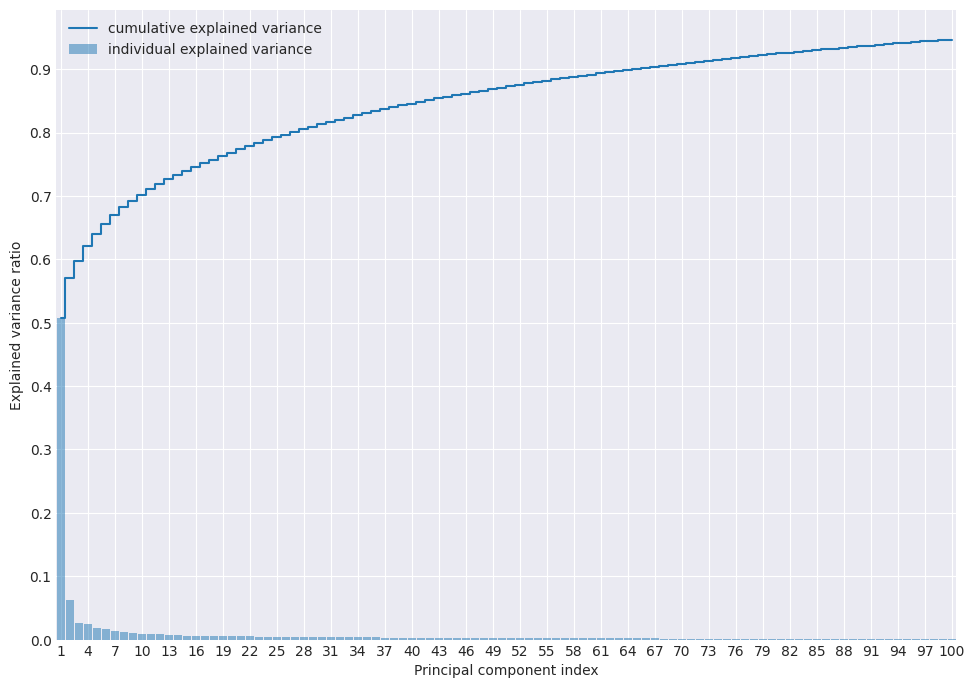

In [7]:
def plotPCAVariance(var_exp: np.ndarray, X: np.ndarray) -> Tuple[plt.Figure, plt.Axes]:
    
    ### STUDENT CODE HERE (3 pts)
    columns_to_plot = 100
    
    cum_var_exp = np.cumsum(var_exp[:columns_to_plot])
    
    #plotting individual explained variance is given
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
    
    ax.bar(range(1,columns_to_plot+1), var_exp[:columns_to_plot], alpha=0.5, align='center',
        label='individual explained variance')
    
    ax.set_ylabel('Explained variance ratio')
    ax.set_xlabel('Principal component index')    
    ax.set_xlim(0.5, columns_to_plot +0.5)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xticks(np.arange(1,columns_to_plot+1,3))

    # plotting
    ax.step(range(1, columns_to_plot+1), cum_var_exp, where='mid',
         label='cumulative explained variance')
    
    ax.legend(loc='best')

    ### STUDENT CODE until HERE

    return fig, ax


# PCA transformation and plot by calling your function

### STUDENT CODE HERE (1 pt)
pca = PCA().fit(x_scaled)
# We have to get the explained variances for all PCs so we don't specify k when we call the PCA().fit() function.
var_exp = pca.explained_variance_ratio_
# Afterwards we can use the result as input for our function and plot the explained variances.
fig, ax = plotPCAVariance(var_exp, x_scaled)
### STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Task:</b>  Now, reduce the number of dimensions using PCA, leaving as many components as necessary to explain at least 90% of the variance of the data. Use the scaled dataset and set a fixed <code>random_state</code> (use the RANDOM_STATE constant).


</div>

In [30]:
X_pca: np.ndarray
### STUDENT CODE HERE (1 pt)
KeepDimensions=65

pca_reducer = PCA(n_components=KeepDimensions, random_state=RANDOM_STATE)
X_pca = pca_reducer.fit_transform(x_scaled)

### STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Task:</b> Use the code block below to find out:
<ul>
    <li> the minimum number of principal components required to cover the 90% of the variance of the data.</li>
    <li> the ratio of the variance covered by the first principal component. Round to two decimal places.</li>
</div>

In [31]:
### STUDENT CODE HERE (1 pt)

cum_var = np.cumsum(var_exp)

# 1. minimum number of PCs needed for 90% variance
min_components_90 = np.argmax(cum_var >= 0.90) + 1   # +1 because index starts at 0

# 2. variance ratio of the first principal component
first_pc_ratio = round(var_exp[0], 2)

print("Number of components for 90% variance:", min_components_90)
print("Variance explained by first PC:", first_pc_ratio)
### STUDENT CODE until HERE

Number of components for 90% variance: 65
Variance explained by first PC: 0.51


<div class="alert alert-block alert-success">
<b>Task:</b> Visualize the data in projection on the first two principal components.


</div>

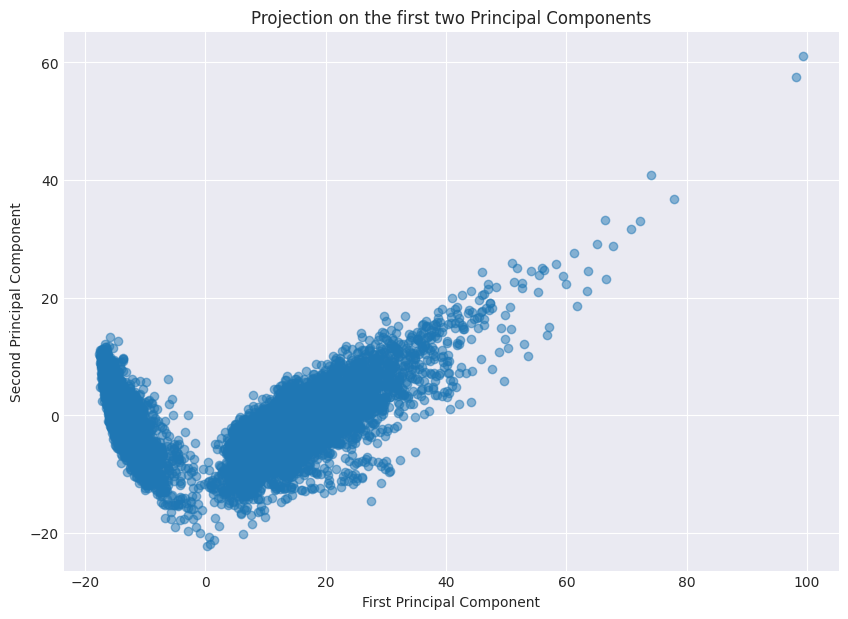

In [49]:
### STUDENT CODE HERE (1 pt)

plt.figure(figsize=(10,7))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Projection on the first two Principal Components')
plt.show()

### STUDENT CODE until HERE


<div class="alert alert-block alert-success">
<b>Question (1 pt):</b> Describe the plot results. What can we conclude looking at the results? What is the benefit of PCA?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> We can see twho blobs. one to the left witch is denser and then another one to the right which is more spread out
</div>

## 3.3 Clustering

<div class="alert alert-block alert-success">
<b>Task:</b> Perform clustering with <code>KMeans</code>, training the model on data with reduced dimensionality (by PCA).

</div>

As a first try, we will look for the number of clusters we see with naked eye. In general case we will not know how many clusters we should be looking for.

Parameters of the K-Means Algorithm:

- **n_clusters** = as noted above
- **n_init** = 100
- **random_state** = RANDOM_STATE (for reproducibility of the result)

Other parameters should have default values.

In [50]:
### STUDENT CODE HERE (1 pt)

n_clusters = 6

kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)

# Get cluster labels
cluster_labels = kmeans.labels_

### STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Task:</b> Visualize your results using the predicted cluster labels as the color of your plot.

</div>

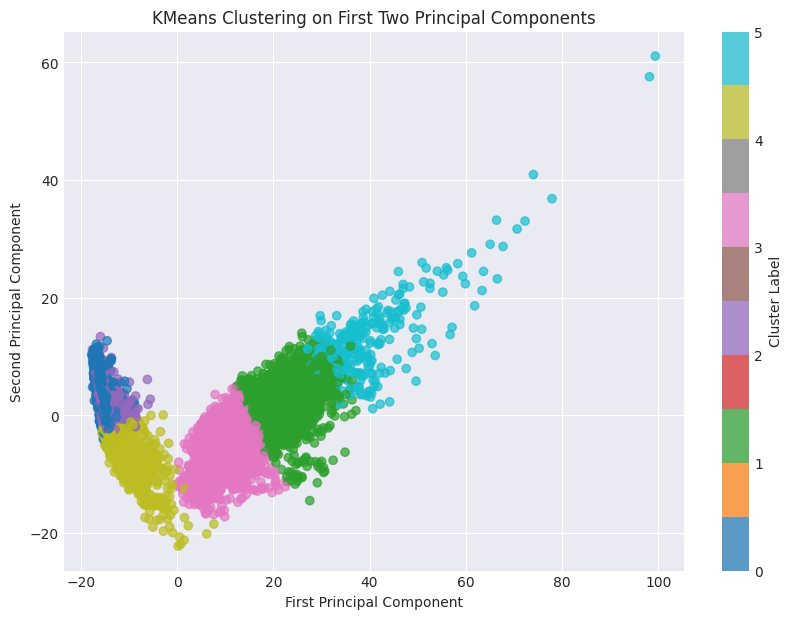

In [51]:
### STUDENT CODE HERE (1 pt)

plt.figure(figsize=(10,7))
plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('KMeans Clustering on First Two Principal Components')
plt.colorbar(label='Cluster Label')
plt.show()

### STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Question (1 pt):</b> What is your interpretation of the clustering result? Describe the plot.
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> It doesn'T seem to be accurate. if we compare the clusters to the activity levels we can see a big difference: While there was a lot of overlap with the activitiy levels there is barely no overlab with the Clusterlabels. We can conclude that the clustering is not accurate.
</div>

### 3.3.1 Varying the number of clusters

Our first estimate of the number of clusters led to a nice result. But what if we could get more information out of the dataset if we vary the number of clusters?

#### 3.3.1.1 Elbow Method

<div class="alert alert-block alert-success">
<b>Task:</b> <ul>
    <li> We want to use the elbow method we learned before to estimate the number of clusters. Therefore, complete the method.</li>
    <li> Use the code below to call your function and plot the loss versus the k-values. Use a range of one to ten for the value of k.</li>
    <li>Use <code>n_init = 10 </code> this time.</li>
</ul>

</div>

Your data looks alright, you can continue with the workbook.


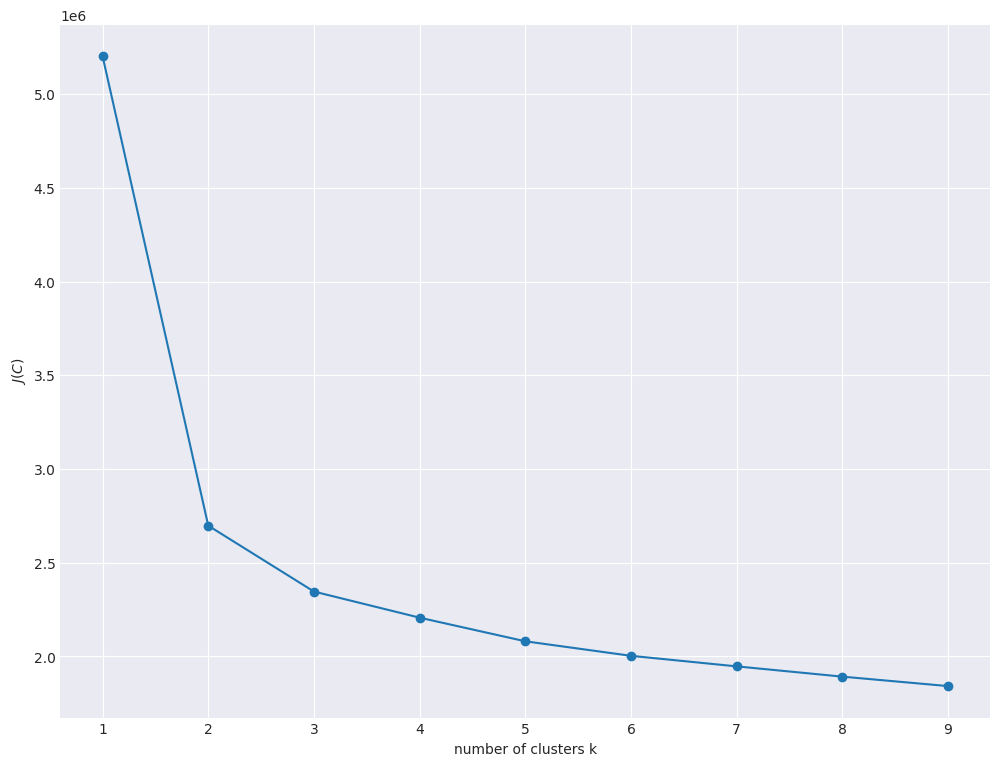

In [52]:
def calculate_k_loss(X: np.ndarray, k_min: int, k_max: int) -> Tuple[List[int], List[float]]:
    k_values: List[int]
    losses: List[float]

    ### STUDENT CODE HERE (3 pts)
    k_values = []
    losses = []
    for k in range(k_min, k_max):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
        kmeans.fit(X)
        #labels_loss = kmeans.predict(X)
        k_values.append(k)
        losses.append(kmeans.inertia_)
    ### STUDENT CODE until HERE
    
    return k_values, losses


# call your function
### STUDENT CODE HERE (1 pt)

k_values, losses = calculate_k_loss(X_pca, 1, 10)
### STUDENT CODE until HERE

# Sanity check - compare your results
test_func.test_calculate_k_loss(calculate_k_loss)

# Plot k_values vs inertias
plt.plot(k_values, losses, '-o')
plt.xlabel('number of clusters k')
plt.ylabel('$ J(C)$')
plt.xticks(k_values)
plt.show()


<div class="alert alert-block alert-success">
<b>Question (1 pt):</b> How many clusters can we choose according to the elbow method?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b>According to the elbow method i would only have to choose 2 cluster. This seems to be a very small number though.
</div>

#### 3.3.1.2 Silhouette Score

Let's use the silhouette score to get a value for $k$.

<div class="alert alert-block alert-success">
<b>Task:</b> Fill in the code below with the function we used in Task 2 already. Get the score for values of $k$ between $2$ and $10$. Use <code>n_init=10</code> again. 

</div>

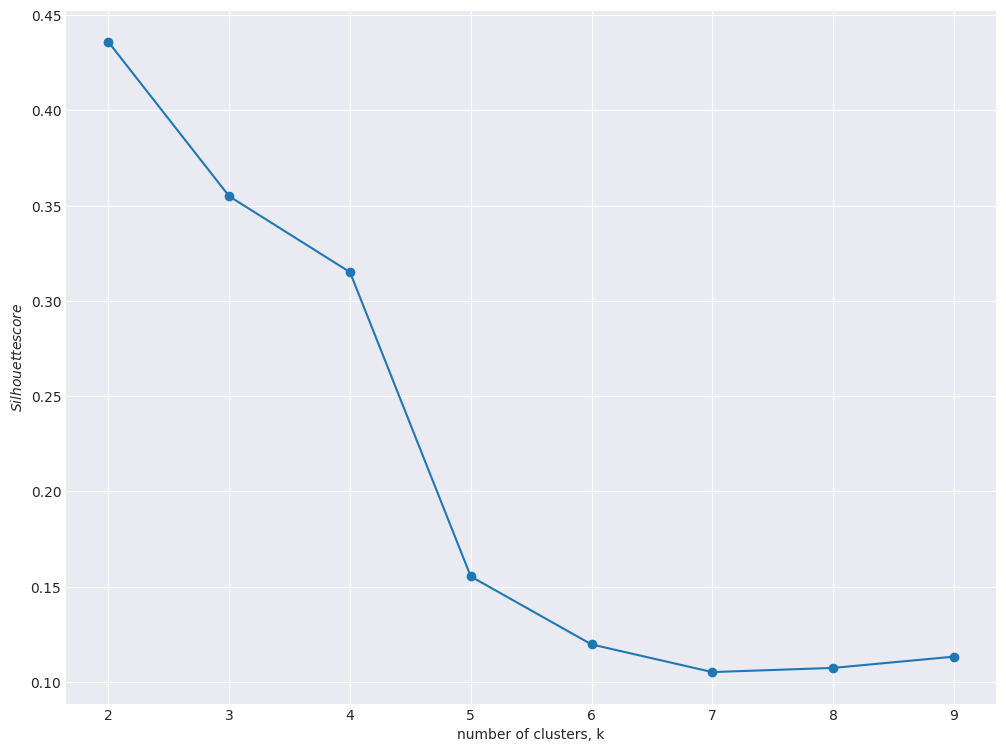

In [53]:
from sklearn.metrics import silhouette_score

def calculate_k_silhouette(X: np.ndarray, k_min: int, k_max: int) -> Tuple[List[int], List[float]]:
    ks: List[int]
    silhouettes: List[float]

    ### STUDENT CODE HERE (3 pts)
    ks = []
    silhouettes = []
    
    for k in range(k_min, k_max):
        sil = KMeans(n_clusters=k, random_state= RANDOM_STATE)
        sil.fit(X)
        labels_k = sil.predict(X)
        ks.append(k)
        silhouettes.append(silhouette_score(X, labels_k))
    ### STUDENT CODE until HERE
    return ks, silhouettes


# call your function
### STUDENT CODE HERE (1 pt)
ks, silhouettes = calculate_k_silhouette(X_pca,2,10)

### STUDENT CODE until HERE

# Plot ks vs inertias
plt.plot(ks, silhouettes, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('$ Silhouette score $')
plt.xticks(ks)
plt.show()


<div class="alert alert-block alert-success">
<b>Question (1 pt):</b> What is your conclusion looking at the results of the two metrics? What value would you choose for $k$?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> The Silhouettescore is highest for k = 2. Thats what i would choose.
</div>

### 3.3.2 Analyzing the given Label Information

#### 3.3.2.1 Class Distribution

<div class="alert alert-block alert-success">
<b>Task:</b> Let's find out how many classes there are actually given in the dataset. Calculate the number of unique values of the labels of the target class. How many data points do we have in each class? Plot a histogram for the distribution of class labels.
</div>

In [54]:
n_classes: int

### STUDENT CODE HERE (2 pts)

# Number of unique classes
n_classes = len(np.unique(y))
print("Number of classes:", n_classes)

# Count samples per class
class_counts = pd.Series(y).value_counts().sort_index()
print("Samples per class:\n", class_counts)

### STUDENT CODE until HERE

Number of classes: 6
Samples per class:
 label
1    1722
2    1544
3    1406
4    1777
5    1906
6    1944
Name: count, dtype: int64


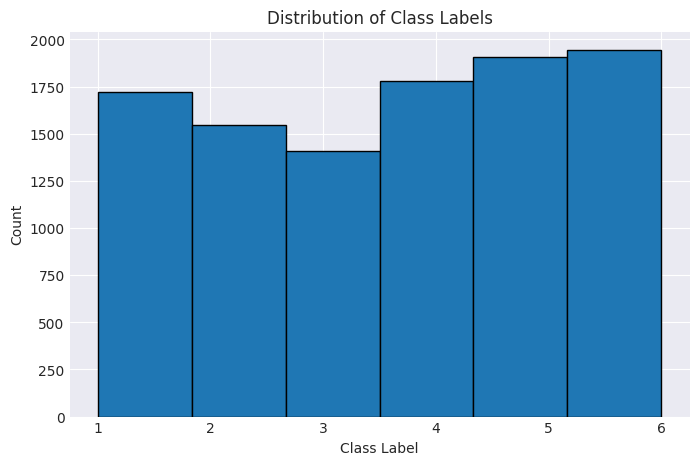

In [55]:
#plotting the histogram
### STUDENT CODE HERE (2 pts)

plt.figure(figsize=(8,5))
plt.hist(y, bins=n_classes, edgecolor='black')
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Distribution of Class Labels")
plt.show()
### STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Question (2 pts):</b> <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names">Have a look at the dataset description.</a>

What do the class labels represent?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> The different activity levels:
<ul>
    <li> 1 – Walking</li> 
    <li> 2 – Walking Upstairs</li> 
    <li> 3 – Walking Downstairs</li> 
    <li> 4 – Sitting</li> 
    <li> 5 – Standing</li> 
    <li> 6 – Laying Down</li> 
</ul>
</div>

#### 3.3.2.2 Showing class distribution with PCA data

To get a better impression of the real classes in the dataset, we want to show the labels of the data points in our PCA transformed dataset.

<div class="alert alert-block alert-success">
<b>Task:</b> Make a scatter plot of the PCA transformed data and mark the classes in different colors.
</div>

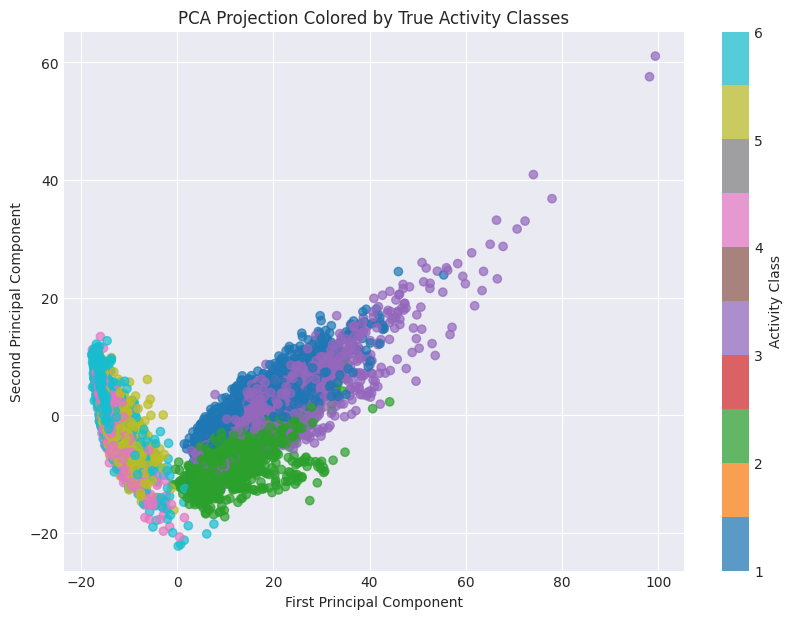

In [56]:
### STUDENT CODE HERE (2 pts)
plt.figure(figsize=(10,7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("PCA Projection Colored by True Activity Classes")
plt.colorbar(label="Activity Class")
plt.show()


### STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Question (2 pts):</b>  If everything worked out correctly, you see the same plot as before in subtask 2, but with label information to every datapoint. What problem do we have looking at the different classes we have in our dataset? What types of activity are included in which visually separated cluster?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b>the 6 classes seem to be clustering into just 2 clusters. in each of these 2 subclusters three clusters heavily overlap. </div>

#### 3.3.2.3 Clustering of PCA data

Let's see if the K-Means algorithm is able to find the true six clusters in the dataset.

<div class="alert alert-block alert-success">
<b>Task:</b> Perform clustering with the <code>KMeans</code> method, training the model on data with reduced dimensionality (by PCA). In this case, we will give a clue to look for exactly 6 clusters, but in general case we will not know how many clusters we should be looking for.
    
Then visualize data in projection on the first two principal components. Color the dots according to the clusters obtained.
</div>

Options:

- **n_clusters** = n_classes (number of unique labels of the target class)
- **n_init** = 100
- **random_state** = RANDOM_STATE (for reproducibility of the result)

Other parameters should have default values.

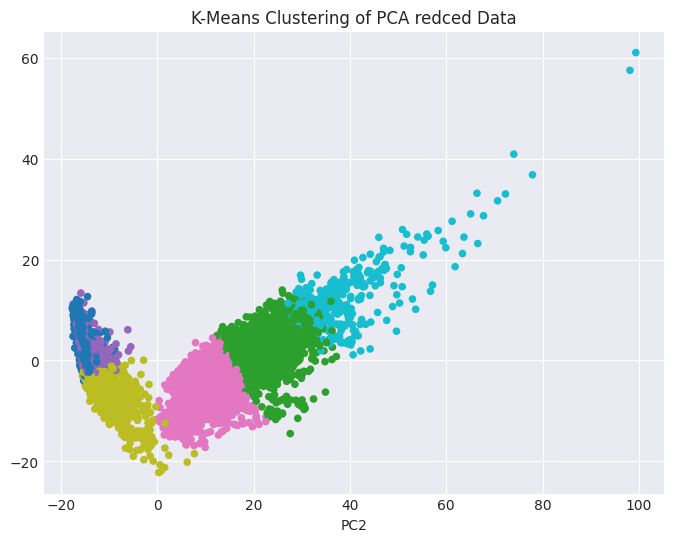

In [64]:
### STUDENT CODE HERE (3 pts)
k_means = KMeans(n_clusters = 6, n_init = 100, random_state=RANDOM_STATE)
clusterLabels = k_means.fit_predict(X_pca)

plt.figure(figsize= (8,6))
plt.scatter(X_pca[:,0], X_pca[:,1],c = clusterLabels,     cmap='tab10',s = 20)
plt.xlabel("PC1")
plt.xlabel("PC2")
plt.title("K-Means Clustering of PCA redced Data")
plt.show()
          

### STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Question (1 pt):</b> Describe the clustering result. What can you see from the resulting plot?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> Still K-Means doesn't satisfy regarding accuracy because it can't deal with the severe overlab of the different Labels. 6 clusters is too much for him. he would be better of clustering for 2 clusters.
</div>

### 3.3.3 Evaluation of Clustering results using labels
The labels of the data can be used to evaluate our clustering results. However, it is not possible to calculate the same metrics as used in classification tasks. In classification, the output of a classification algorithm is exactly one of the learned classes. In comparison to that, a clustering algorithm only performs an assignment to one cluster, but we do not know  which class a cluster has found. 

#### 3.3.3.1 Cross-Tabulation

<div class="alert alert-block alert-success">
<b>Task:</b> Look at the correspondence between the cluster marks and the original class labels. Therefore, calculate a cross-tabulation of the cluster labels and the real labels of the data points.
    
<b>Hint:</b> Use crosstab from the pandas library
</div>

In [67]:
### STUDENT CODE HERE (2 pts)
ct = pd.crosstab(y, cluster_labels, rownames=['True Label'], colnames=['Cluster'])
display(ct)
### STUDENT CODE until HERE

Cluster,0,1,2,3,4,5
True Label,,,,,,
1,0,740,0,904,0,78
2,0,296,0,1241,2,5
3,0,890,0,320,0,196
4,90,0,1235,1,451,0
5,0,0,1344,0,562,0
6,1556,0,53,5,330,0


<div class="alert alert-block alert-success">
<b>Question (1 pt):</b>  What kinds of activities is the <code>KMeans</code> algorithm confused with?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> The more logic two clusters would be: Active( Walking, W. Upstairs, W. Downstairs) and Resting(laying down, sitting, standing). He confuses them because they are similar
</div>

#### 3.3.3.2 Developing a simple separation metric
We are observing that each class, representing a specific activity, is grouped into distinct clusters. To assess how effectively a particular class is distinguished, we will employ a metric. This metric involves identifying the highest value within each class and then dividing it by the total number of instances belonging to that class. This will give a percentage value that shows, how well the class can be clustered.


Example: if for class "walking downstairs" (with 1406 instances belonging to it), the distribution of clusters is:
 - cluster 1 - 900
 - cluster 3 - 500
 - cluster 6 - 6,
 
then such a share will be 900/1406 $ \approx $ 0.64.


<div class="alert alert-block alert-success">
<b>Task:</b> Calculate this value for all classes.
</div>

In [68]:
### STUDENT CODE HERE (3 pts)

cluster_quality = ct.max(axis=1) / ct.sum(axis=1)

cluster_quality


### STUDENT CODE until HERE

True Label
1    0.524971
2    0.803756
3    0.633001
4    0.694992
5    0.705142
6    0.800412
dtype: float64

<div class="alert alert-block alert-success">
<b>Question (2 pt):</b>  Answer the following questions in the answer block below and indicate which question your answer is referring to: <br>
    
1. Which activities are separated from the rest better than others based on the simple metric described above? <br>
2. How would you rate the results in general? Do you have an explanation for the results?
</div>

<div class="alert alert-block alert-success">
<b>Your Answer:</b> 
    
1. <br> The second and sixth. Walking upstairs and laying down.
2. The result is not satisfying. Preferably they would be clusterd overwhelmingly correct. I assume this result is due to 2 and 6 being the edges on the scale from least active to most active. Thereby not intersecting a little less. 
</div>

------------------------
## 3.4 Classification with Decision Trees and K-Nearest-Neighbor

You can notice that the task of clustering the given dataset is not very well solved when we try to detect several clusters (> 2). Now, let's solve the classification problem, given that the data is labeled.

For classification, use the nearest neighbor classifier – class `sklearn.neighbors.KNeighborsClassifier` and the Decision Tree Classifier – class `sklearn.tree.DecisionTreeClassifier`. We studied these algorithms in course three.

The overall idea for this last part is to make the influence of the PCA algorithm visible. Therefore, first, you will train and evaluate both classifiers on the complete dataset.
Second, you are going to reduce the dimensionality of the data using the PCA algorithm, before training and evaluating both classifiers again.


### 3.4.1 Choosing the best hyperparameters for the algorithms using Cross-Validation

Choose the `n_neighbors` hyperparameter for` KNeighborsClassifier` and the pruning parameter `max_depth` using `GridSearchCV`. 



<div class="alert alert-block alert-success">
<b>Task:</b> First step: Fit the  <code>StandardScaler</code> on the training set (with all original features), but perform only mean centering. Apply scaling to the test set.

</div>

In [70]:
X_train_scaled: np.ndarray
X_test_scaled: np.ndarray

### STUDENT CODE HERE (2 pts)

scaler = StandardScaler(with_std=False)   # mean-centering only

# Fit on training set
scaler.fit(X_train)

# Transform both sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


### STUDENT CODE until HERE

# Sanity Check
assert (np.abs(np.mean(X_train_scaled)) < 0.000000001) ^ (np.abs(np.mean(X_test_scaled)) < 0.000000001), f'Expected either train or test set to be fitted for scaling.'

<div class="alert alert-block alert-success">
<b>Task:</b> Second Step: 
Specify a list of parameter values for the Decision Tree and KNeighborsClassifier you want to be evaluated.

</div>

For example:
- Tree: max_depth: None, 5, 10, 15
- KNN: n_neighbors: 3, 5, 7, 9, 11

In [88]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#%time
### STUDENT CODE HERE (2 pts)

# Parameter grids
tree_params = {
    "max_depth": [None, 9, 10, 11]
}

knn_params = {
    "n_neighbors": [8, 9, 10]
}


### STUDENT CODE until HERE


# Use the Grid Search CV for Tree with cv=3 and fixate the 
# random state of the Decision Tree classifier with RANDOM_STATE

### STUDENT CODE HERE (2 pts)

tree_clf = DecisionTreeClassifier(random_state=RANDOM_STATE)

grid_tree = GridSearchCV(
    estimator=tree_clf,
    param_grid=tree_params,
    cv=3
)

grid_tree.fit(X_train_scaled, y_train)


### STUDENT CODE until HERE


# Do the same Grid Search CV for KNN, again with cv=3 and RANDOM_STATE

### STUDENT CODE HERE (1 pt)

knn_clf = KNeighborsClassifier()

grid_knn = GridSearchCV(
    estimator=knn_clf,
    param_grid=knn_params,
    cv=3
)

grid_knn.fit(X_train_scaled, y_train)


### STUDENT CODE until HERE


# Get the best params, classification score and the model itself for both, the Tree and the KNN

### STUDENT CODE HERE (2 pts)
best_knn = grid_knn.best_estimator_
best_knn_score = grid_knn.best_score_
best_tree = grid_tree.best_estimator_
best_tree_score = grid_tree.best_score_

print("best knn:", best_knn)
print("best knn score:" , best_knn_score)
print("best tree:", best_tree)
print("best tree score:", best_tree_score)

### STUDENT CODE until HERE

# Sanity check - compare your results
test_func.test_best_knn_score(best_knn_score)
test_func.test_best_tree_score(best_tree_score)

best knn: KNeighborsClassifier(n_neighbors=9)
best knn score: 0.8928212002875405
best tree: DecisionTreeClassifier(max_depth=10, random_state=42)
best tree score: 0.8328326908078614
Your data looks alright, you can continue with the workbook.
Your data looks alright, you can continue with the workbook.


<div class="alert alert-block alert-success">
<b>Question (1 pt):</b> Which value of the hyperparameter <code>n_neighbors</code> was chosen the best on the basis of cross-validation? What depth of the tree was selected? Which classifier performed better?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> the best n_neigbors parameter is: 9 with a score of 0.893. The best depth for the tree is 10 with a score of 0.832. The KNN Clssifier was slightly better.
</div>

### 3.4.2 Scoring the Test Set

<div class="alert alert-block alert-success">
<b>Task:</b> Now use the best parameter set for the two algorithms and train them on the whole training dataset. Predict the labels of the test set with these models and calculate the accuracy of the two models.

</div>

In [75]:
### STUDENT CODE HERE (2 pts)
from sklearn.metrics import accuracy_score
# Train best models on full training set
best_knn.fit(X_train_scaled, y_train)
best_tree.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_knn = best_knn.predict(X_test_scaled)
y_pred_tree = best_tree.predict(X_test_scaled)

# Calculate accuracy
knn_test_accuracy = accuracy_score(y_test, y_pred_knn)
tree_test_accuracy = accuracy_score(y_test, y_pred_tree)

print("KNN Test Accuracy:", knn_test_accuracy)
print("Decision Tree Test Accuracy:", tree_test_accuracy)

### STUDENT CODE until HERE
### STUDENT CODE until HERE

KNN Test Accuracy: 0.9053274516457415
Decision Tree Test Accuracy: 0.8625721072276892


<div class="alert alert-block alert-success">
<b>Question (1 pt):</b> Which algorithm performs better on the test set? Which algorithm has better generalization abilities? Interpret the results.
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> KNN performed better with an Accuracy score of 0.905 versus 0.86 by the Decision Tree. This also means that the KNN generalized better, right? Because it was better able to detect the classes in foreign data. 
</div>

### 3.4.3 Adding PCA to the Classification 

<div class="alert alert-block alert-success">
<b>Task:</b> Finally, do the same thing as in the Question before, but add PCA with the typical value of explained variance we discussed before.
<ul>
<li> Use <code>X_train_scaled</code> and <code>X_test_scaled</code>
<li> Train the PCA as before, on the scaled training set
<li> Apply PCA transformation to the test set

</li>
</ul>
</div>

In [85]:
X_train_pca: np.ndarray
X_test_pca: np.ndarray

### STUDENT CODE HERE (2 pts)

pca = PCA(n_components=34, random_state=RANDOM_STATE)
pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

### STUDENT CODE until HERE

assert(X_train_pca.shape == (7352, 34)), f'For the dataset a different shape was expected'
assert(X_test_pca.shape == (2947, 34)), f'For the dataset a different shape was expected'

<div class="alert alert-block alert-success">
<b>Task:</b> Choose the hyperparameters via cross-validation on the training set with PCA-transformation. (Just copy your code from above but use the PCA-transformed dataset)

</div>

<div class="alert alert-block alert-success">
<b>Question (1 pt):</b> Do you notice a speed difference for the training process? What do you observe if you compare the optimal hyperparameters?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> langsamer?
</div>

In [86]:
%time
### STUDENT CODE HERE (2 pts)

# Parameter grids
params_tree = {'max_depth': [None, 9, 10, 11]}
params_knn = {'n_neighbors': [8, 9, 10]}

# GridSearch for Decision Tree
tree_cv_pca = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid=params_tree,
    cv=3
)
tree_cv_pca.fit(X_train_pca, y_train)

# GridSearch for KNN
knncv_classifier = KNeighborsClassifier()

knn_cv_pca = GridSearchCV(
    estimator=knncv_classifier,
    param_grid=params_knn,
    cv=3
)
knn_cv_pca.fit(X_train_pca, y_train)


### STUDENT CODE until HERE

CPU times: user 6 μs, sys: 0 ns, total: 6 μs
Wall time: 11.7 μs


,estimator,KNeighborsClassifier()
,param_grid,"{'n_neighbors': [8, 9, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,9


<div class="alert alert-block alert-success">
<b>Task:</b> Now finally evaluate the results on the test set. Use the accuracy metric. Access the best estimator of the <code>GridSearchCV</code> of the block before. Do not train a new model.  

</div>

In [89]:
### STUDENT CODE HERE (2 pts)

best_knn_pca = knn_cv_pca.best_estimator_
best_tree_pca = tree_cv_pca.best_estimator_

y_pred_knn_pca = best_knn_pca.predict(X_test_pca)
y_pred_tree_pca = best_tree_pca.predict(X_test_pca)

knn_pca_accuracy = accuracy_score(y_test, y_pred_knn_pca)
tree_pca_accuracy = accuracy_score(y_test, y_pred_tree_pca)

print("KNN PCA Test Accuracy:", knn_pca_accuracy)
print("Decision Tree PCA Test Accuracy:", tree_pca_accuracy)


### STUDENT CODE until HERE

KNN PCA Test Accuracy: 0.8815744825246012
Decision Tree PCA Test Accuracy: 0.824906684764167


<div class="alert alert-block alert-success">
<b>Question (2 pts):</b> What do you observe? What is the difference between the best quality (accuracy) for the test set in the case of all 561 initial characteristics and in the second case, when the principal component method was applied? Round to the nearest percent. Do you have an explanation for the different behavior of the two algorithms?
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> 
</div>

<div class="alert alert-block alert-success">
<b>Question (2 pts):</b>  Select all the correct statements:
<ul>
<li> Principal component analysis in this case allowed to reduce the model training time, while the quality (accuracy) stays nearly the same
<li> PCA can be used to visualize data, but there are better methods for this task, for example, [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). However, PCA has lower computational complexity 
<li> PCA builds linear combinations of initial features, and in some applications they might be poorly interpreted by humans 
</li>
</ul>
</div>
<div class="alert alert-block alert-success">
<b>Your Answer:</b> 
</div>

# Feedback and Recap

<div class="alert alert-block alert-success">
<b>Question (3pt):</b>  Please conclude in a few sentences what you learned in this exercise
</div>

<div class="alert alert-block alert-success">
<b>Your Answer:</b> 
</div>

## And give us feedback if you like


1) Do you think this task was designed well? 

2) Where can we improve this task?

<strong>Thanks for participating in LAMA! :)</strong>